# FIABILITE

## Jérôme PAYEN, Valentin ROBERT, Vinh-Hoa TU

### Partie II : DÉTERMINATION DE LA HAUTEUR DE LA DIGUE À PARTIR DES RELEVÉS DE MESURE HISTORIQUES

Nous avons accès aux données historiques de 1849 à 1997 seulement. Les données sont le débit d'eau Q maximum à l'année associé à la hauteur de l'eau H. Nous voulons à partir de ces données proposer une hauteur $h_d$ de la digue de façon à minimiser le risque d'inondation.

#### Import des données et des librairies

In [5]:
# Import des librairies
library(evd)
library(readxl)
library(ggplot2)
library(triangle)
library(nortest)

Warning message:
"le package 'evd' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'readxl' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'ggplot2' a été compilé avec la version R 4.3.2"
Warning message:
"le package 'triangle' a été compilé avec la version R 4.3.3"


In [6]:
data <- read_excel("Data/Données-Projet-Pratique-Fiabilité-ISUP-DS_E-Remy_2024-2025.xlsx")
colnames(data) <- c("Annee", "Debit", "Hauteur")
data_clean <- na.omit(data)

#### Représentations graphiques

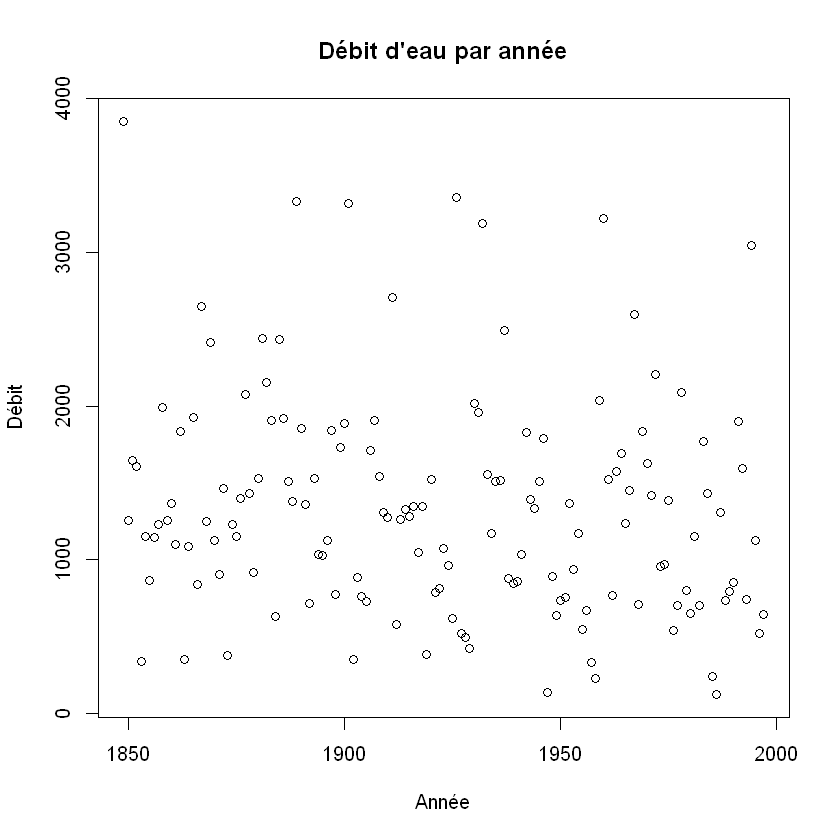

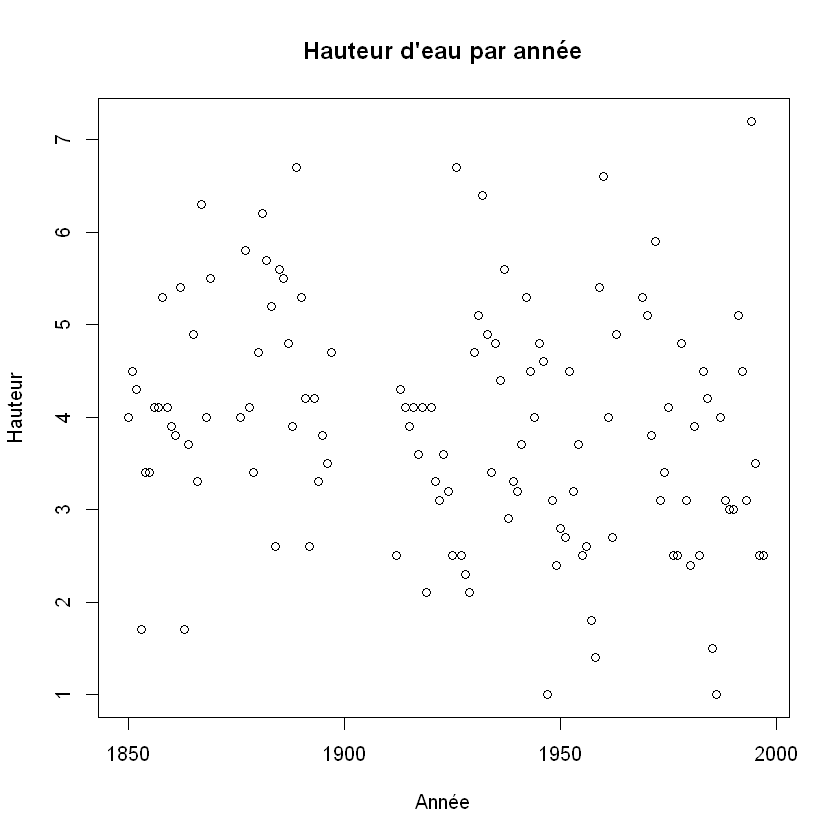

In [7]:
plot(x=data$Annee, y=data$Debit, xlab="Année", ylab="Débit", main="Débit d'eau par année" )
plot(x=data$Annee,y=data$Hauteur, xlab="Année", ylab="Hauteur", main="Hauteur d'eau par année" )

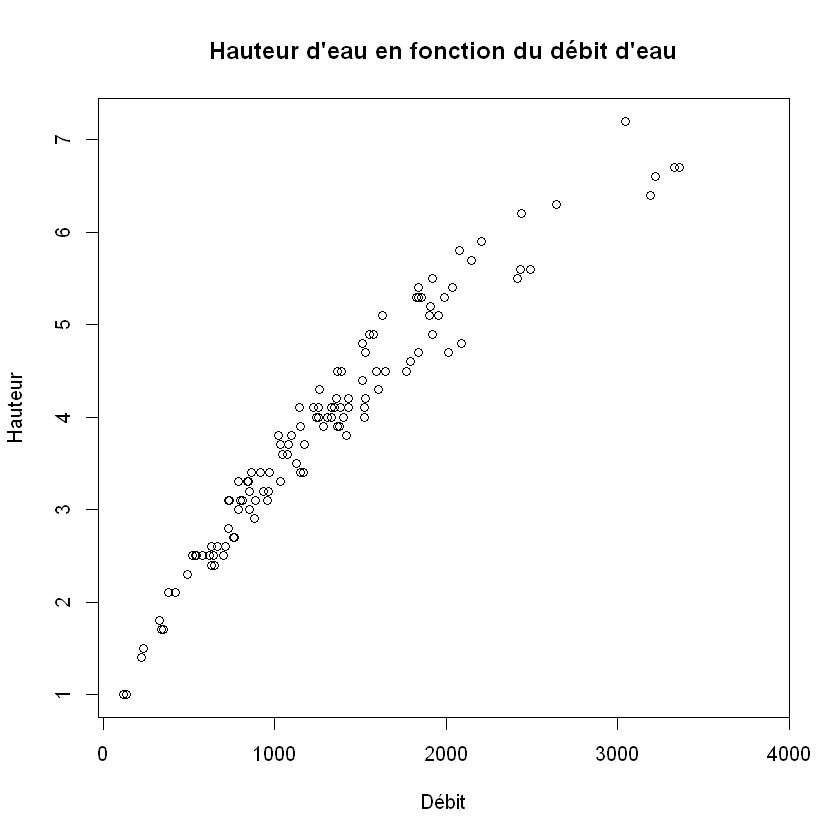

In [8]:
plot(x = data$Debit, y = data$Hauteur, xlab="Débit", ylab="Hauteur", main="Hauteur d'eau en fonction du débit d'eau")

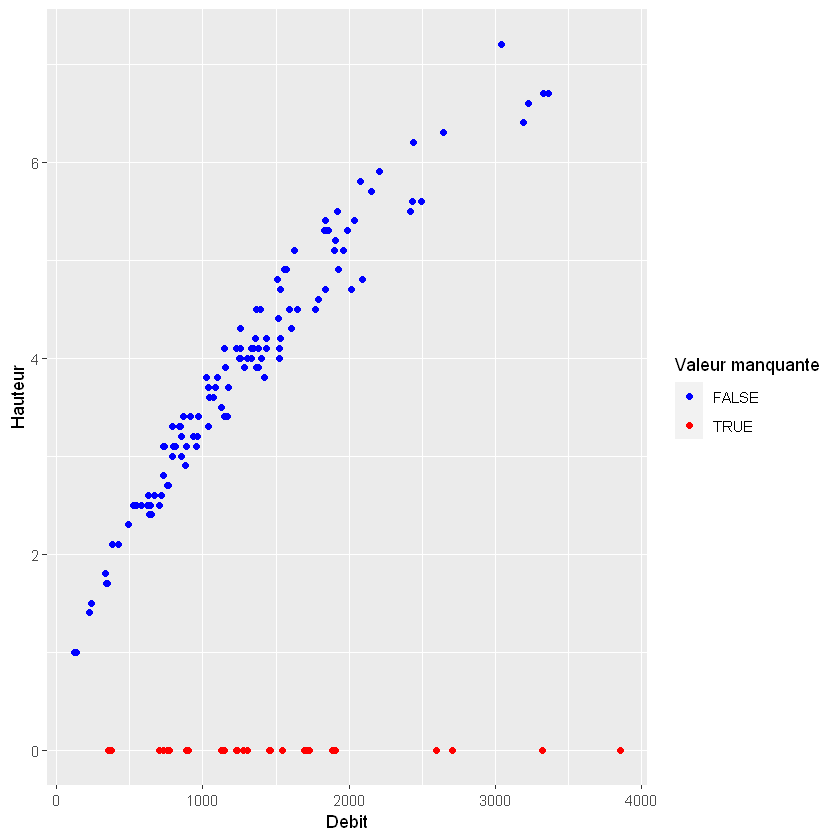

In [9]:
data[is.na(data)] <- 0
ggplot(data = data, aes(x = Debit, y = Hauteur)) +
  geom_point(aes(color = (Hauteur == 0))) + 
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "blue")) +
  labs(color = "Valeur manquante") 
  

In [10]:
cor(sqrt(data_clean$Debit), data_clean$Hauteur)

[1] 0.9804531

#### Modélisation de la relation Debit-Hauteur

In [11]:
# Modélisation par régréssion linéaire avec transformation de la variables Debit
model_glm <- lm(Hauteur ~ sqrt(Debit), data=data_clean)  
summary(model_glm)


Call:
lm(formula = Hauteur ~ sqrt(Debit), data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52265 -0.21498 -0.01522  0.17077  0.63911 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.664844   0.086249  -7.708 3.96e-12 ***
sqrt(Debit)  0.130958   0.002389  54.815  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2514 on 121 degrees of freedom
Multiple R-squared:  0.9613,	Adjusted R-squared:  0.961 
F-statistic:  3005 on 1 and 121 DF,  p-value: < 2.2e-16


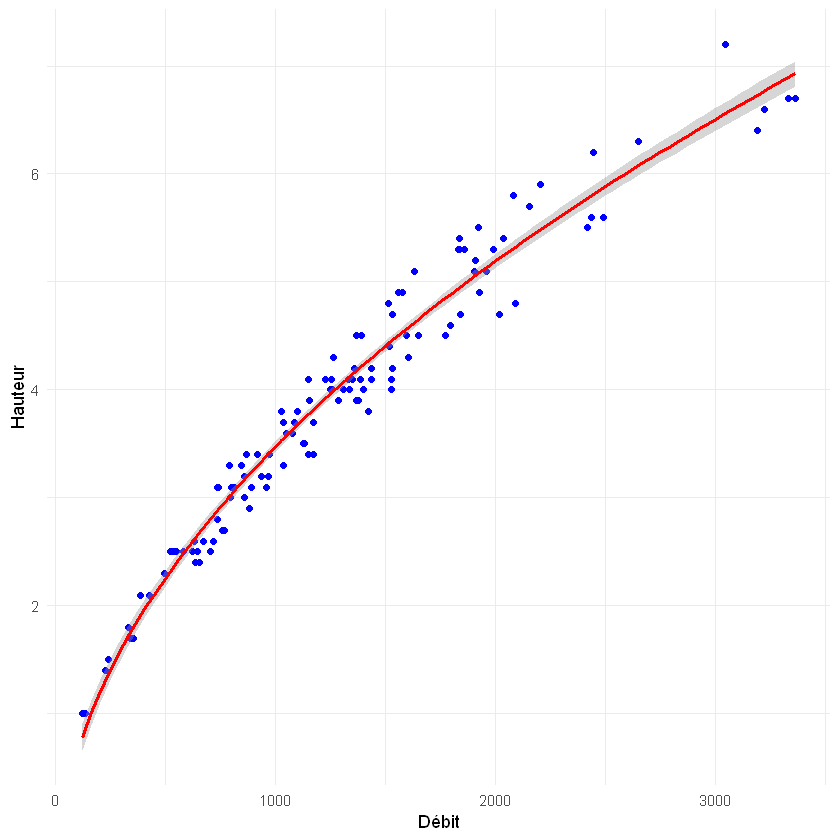

In [12]:
# Tracer les données et ajouter la courbe de régression 
ggplot(data_clean, aes(x = Debit, y = Hauteur)) +
  geom_point(color = "blue") +  # Affichage des points
  geom_smooth(method = "lm", formula = y ~ sqrt(x), color = "red", level = 0.95) +  # Courbe de régression avec intervalle de confiance à 95%
  labs(x = "Débit",
       y = "Hauteur") +
  theme_minimal()

#### Gestion des valeurs manquantes

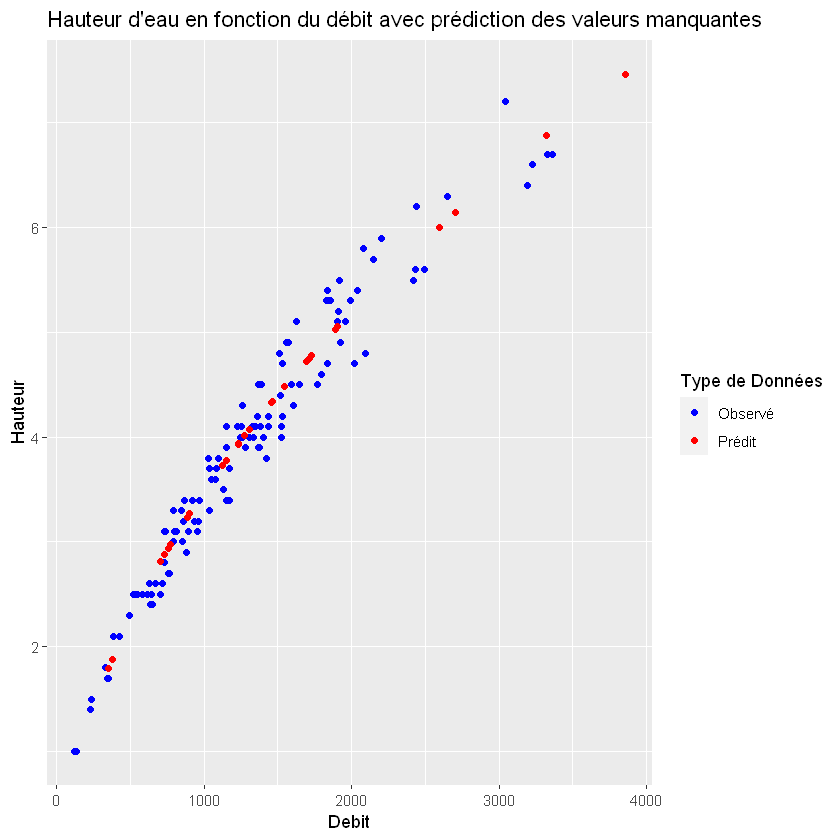

In [13]:
#projection des prédictions sur la courbe de régression
data_na <- data[data$Hauteur == 0,]
predictions <- predict(model_glm,data_na[, "Debit"],interval='conf',level=0.999999)
pred <- cbind(predictions, data_na[, -3])

# Ajouter une colonne "Source" pour identifier chaque dataframe
data_clean$Source <- "Observé"
pred$Source <- "Prédit"

# Renommer la colonne "fit" de pred pour correspondre à "Hauteur"
colnames(pred)[colnames(pred) == "fit"] <- "Hauteur"

# Fusionner les deux dataframes
df_combined <- rbind(data_clean, pred[,c("Annee", "Debit", "Hauteur", "Source")])

# Tracer avec ggplot
ggplot(df_combined, aes(x = Debit, y = Hauteur, color = Source)) +
  geom_point() +
  scale_color_manual(values = c("Observé" = "blue", "Prédit" = "red")) +
  labs(color = "Type de Données", title="Hauteur d'eau en fonction du débit avec prédiction des valeurs manquantes")



In [14]:
data_fill <- data
rank <- 1
for (i in 1:nrow(data_fill)){
    if (data_fill[i, "Hauteur"] == 0){
        data_fill[i, "Hauteur"] <- pred[rank, "Hauteur"]
        rank <- rank+1
    }
}

### 3 modèles d'estimations de hauteur de digue avec les données historiques

Le deux premiers modèles consistent à modéliser la relation entre la hauteur et le débit d'eau.  
Puis nous modélisons les résidus de la régression et enfin nous prenons en compte l'incertitude de la côte en aval Zv.  
Le troisième modèle correspond à l'utilisation de simulations Monte-Carlo. Nous pouvons modéliser la hauteur de surverse avec des variables aléatoires et donc nous allons simuler plusieurs valeurs de surverse et calculer le quantile empirique à 99.99%.

Le premier modèle sera très conservateur. Pour la loi de Gumbel et la la loi des résidus, nous prendrons un quantile très élevé de niveau 0.9999 et nous prendrons le max de Zv qui suit une loi triangulaire.  
Le deuxième modèle est plus modéré et nous ne prendrons pas en compte les résidus de la modélisation et prendrons la moyenne de Zv.  
Le dernier modèle est plus robuste car il ne pose pas la question de savoir si le cumul des incertitudes est additif ou multiplicatif.

#### Modélisation de la relation entre la hauteur et le débit d'eau


	Shapiro-Wilk normality test

data:  data$Debit
W = 0.93877, p-value = 4.564e-06



	Anderson-Darling normality test

data:  data$Debit
A = 2.0762, p-value = 2.648e-05


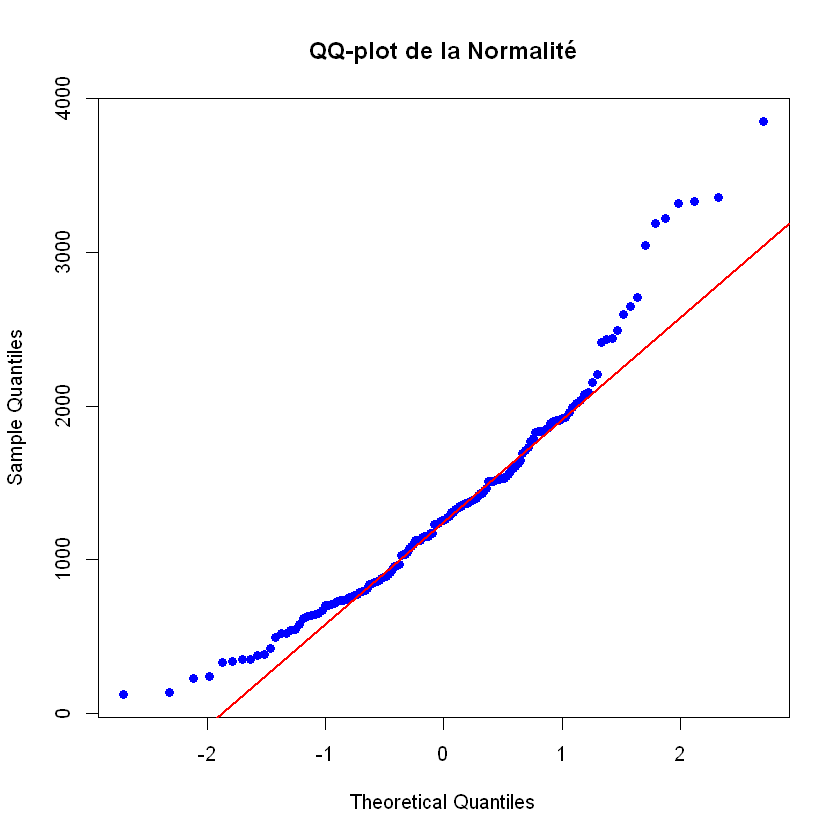

In [15]:
qqnorm(data$Debit, main = "QQ-plot de la Normalité", pch = 19, col = "blue")
qqline(data$Debit, col = "red", lwd = 2)  # Ajouter la ligne de référence
shapiro.test(data$Debit) # On rejette le test de normalité
nortest::ad.test(data$Debit) # On rejette le test de normalité

In [16]:
# Paramètres de la loi de Gumbel
mode <- 1013
echelle <- 558

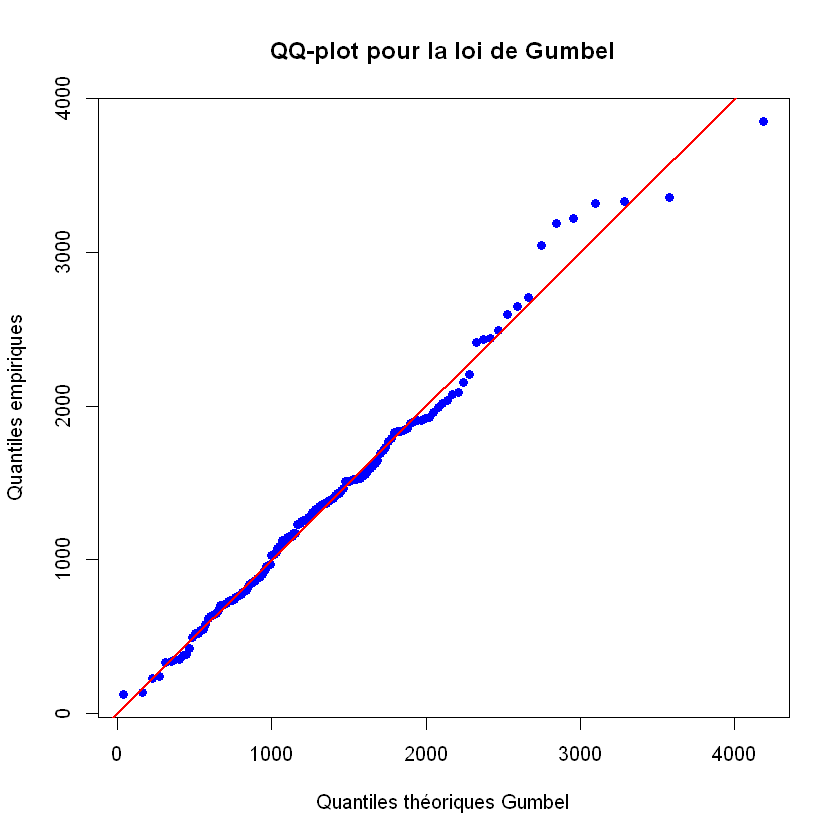

In [17]:
# Trier les données empiriques
data_empirique <- sort(data$Debit)

# Générer des quantiles théoriques de la loi de Gumbel
n <- length(data_empirique)
quantiles_theoriques <- qgumbel(ppoints(n), loc = mode, scale = echelle)

# QQ-plot
qqplot(quantiles_theoriques, data_empirique, main = "QQ-plot pour la loi de Gumbel",
       xlab = "Quantiles théoriques Gumbel", ylab = "Quantiles empiriques",
       pch = 19, col = "blue")

# Ajouter la ligne de référence
abline(0, 1, col = "red", lwd = 2)

#### Modélisation des résidus

In [18]:
# Extraire les résidus
residus <- residuals(model_glm)

# Calculer l'écart-type des résidus
ecart_type_res <- sd(residus)


	Shapiro-Wilk normality test

data:  residus
W = 0.98382, p-value = 0.1492



	Anderson-Darling normality test

data:  residus
A = 0.62467, p-value = 0.1015


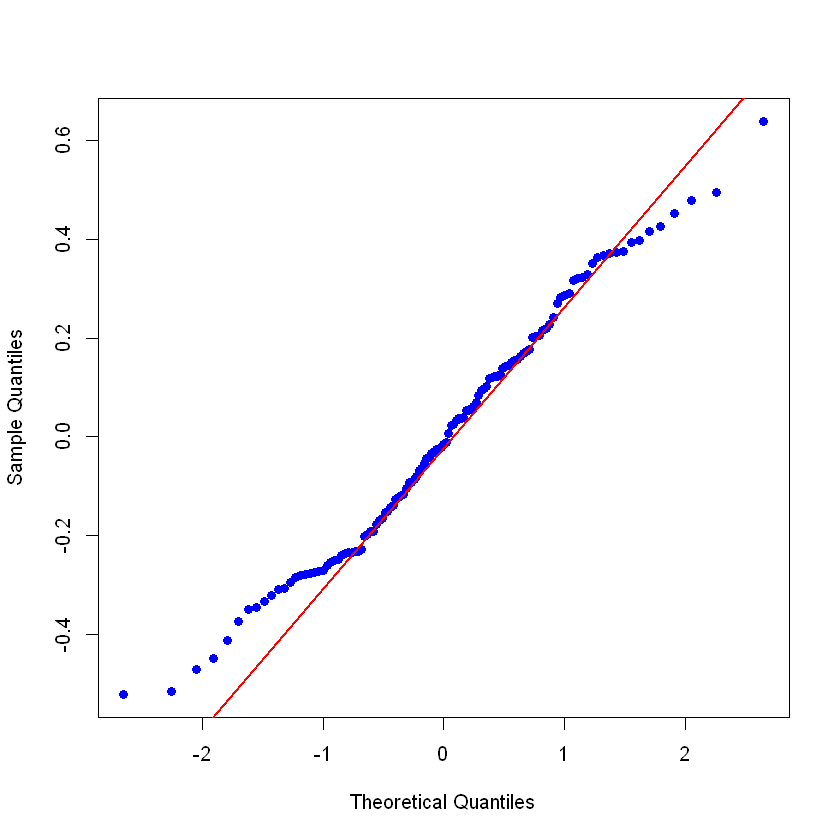

In [19]:
qqnorm(residus, main="", pch = 19, col = "blue")
qqline(residus, col = "red", lwd = 2)  # Ajouter la ligne de référence
shapiro.test(residus) # On rejette le test de normalité
nortest::ad.test(residus)

#### Estimation de la hauteur de la digue

##### Estimation conservatrice

In [23]:
#Paramètres Zv
mu_Zv <- 50
min_Zv <- 49
max_Zv <- 51

#Côte de la berge
Zb <- 55.5

In [ ]:
# Calcul de la valeur seuil pour 99.99% des données des résidus
quantile <- mode - echelle*log(-log(0.9999)) # = 6152
hauteur_eau <- predict(model_glm,data.frame("Debit" = quantile))

# Calculer le quantile 99.99%
quantile_95_norm <- qnorm(0.9999) * ecart_type_res

hauteur_eau <- hauteur_eau + quantile_95_norm
cat("La hauteur d'eau auquel il faut se protéger est de ", hauteur_eau,"m.","\n")

# Calcul de la hauteur de surverse qui correspond à la hauteur de la digue
Zc <- hauteur_eau + max_Zv 
hauteur_digue <- Zc - Zb

cat("Il faut une hauteur de digue de ", hauteur_digue, "m pour le modèle conservateur.")

La hauteur d'eau auquel il faut se protéger est de  12.75555 m. 
Il faut une hauteur de digue de  8.255547 m pour le modèle conservateur.

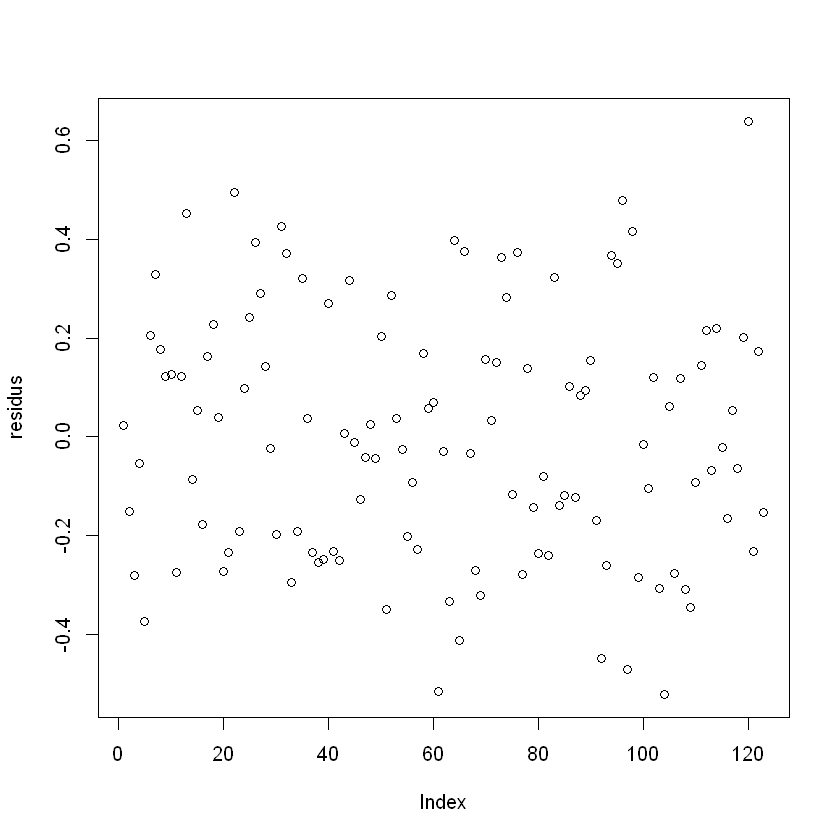

In [25]:
plot(residus)

In [31]:
mean(residus)

[1] -1.061615e-18

##### Estimation modérée

In [ ]:
# Calcul de la valeur seuil pour 99.99% des données des résidus
quantile <- mode - echelle*log(-log(0.9999)) # = 6152
hauteur_eau <- predict(model_glm,data.frame("Debit" = quantile))

cat("La hauteur d'eau auquel il faut se protéger est de ", hauteur_eau,"m.","\n")

# Calcul de la hauteur de surverse qui correspond à la hauteur de la digue
Zc <- hauteur_eau + mu_Zv 
hauteur_digue <- Zc - Zb

cat("Il faut une hauteur de digue de ", hauteur_digue, "m pour le modèle modéré.")

La hauteur d'eau auquel il faut se protéger est de  9.607105 m. 
Il faut une hauteur de digue de  4.107105 m.

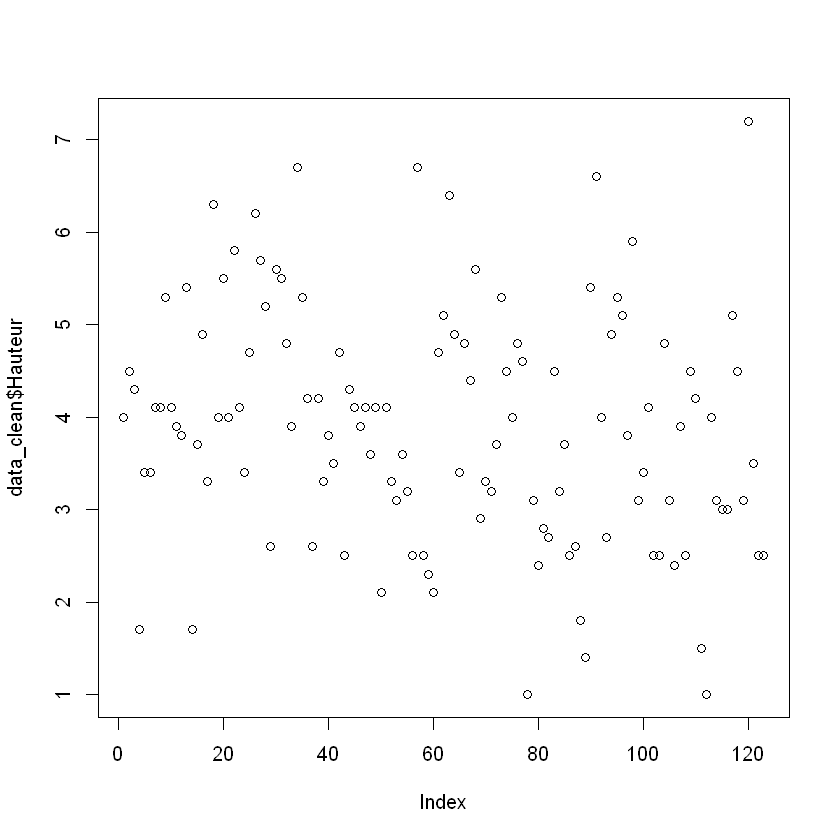

In [21]:
plot(data_clean$Hauteur)

In [18]:
listevar <- list()
j <- 1
# calculer écart de variance toutes les 10 valeurs
for (i in seq(1,nrow(data_clean),by=25)){
    listevar[j] <- var(data_clean[i:(i+25),"Hauteur"])
    j <- j+1
}

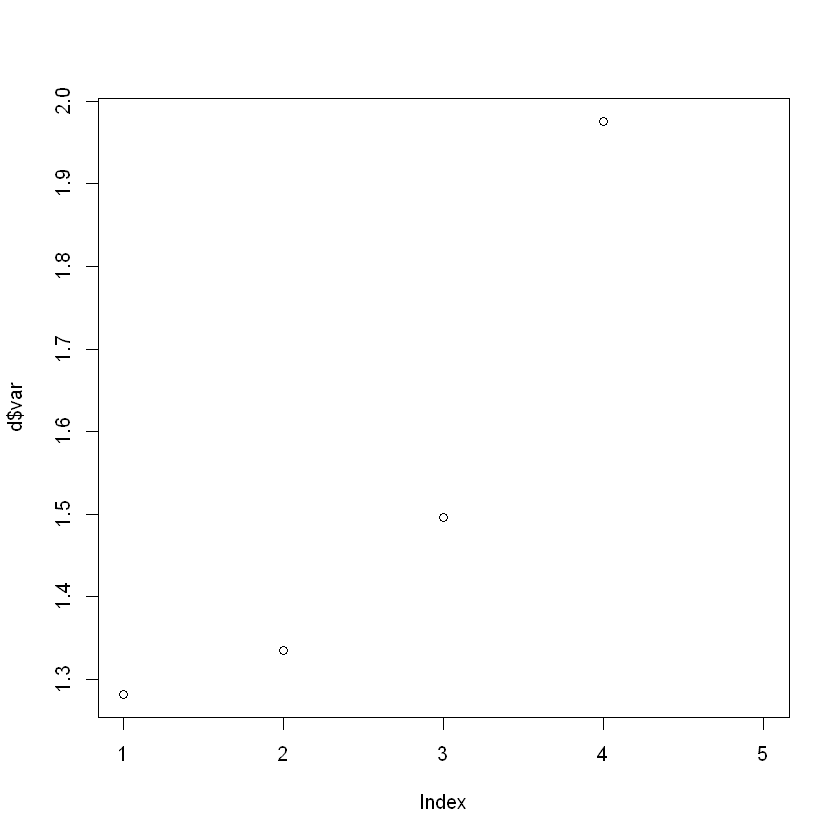

In [19]:
d <- do.call(rbind.data.frame, listevar)
colnames(d) <- c("var")
plot(d$var)

On prendre rajouter une marge de sécurité qui comprend les changements climatiques, ce changement de variance et tout événement imprédictible

##### Estimation simulation Monte Carlo

In [27]:
set.seed(123)
#Nombre d'échantillons
n <- 1000000


#Paramètres déterministes
Zb <- 55.5

#Paramètres epsilon
mu <- mean(residus)
sigma <- sd(residus)

#Paramètres Q
loc_Q <- 1013
scale_Q <- 558

#Paramètres Zv
mu_Zv <- 50
min_Zv <- 49
max_Zv <- 51

# Simulations des variables aléatoires
Zv <- rtriangle(n, a = min_Zv, b = max_Zv, c = mu_Zv)
Q <- rgumbel(n, loc = loc_Q, scale = scale_Q)
epsilon <- rnorm(n, mu, sigma)
# On retire des débits si les débits sont négatifs
while (any(Q < 0)) {
Q[Q < 0] <- rgumbel(sum(Q < 0), loc = loc_Q, scale = scale_Q)
}
f_Q <- model_glm$coefficients[1] + sqrt(Q)*model_glm$coefficients[2]

# Calcul de la hauteur de la digue
h_d <- Zv + f_Q + epsilon - Zb

In [28]:
quantile_empirique <- quantile(h_d, probs = 0.9999, type = 7)
print(quantile_empirique)

  99.99% 
4.366599 


In [63]:
sum(h_d > 0)/length(h_d)

[1] 0.123901

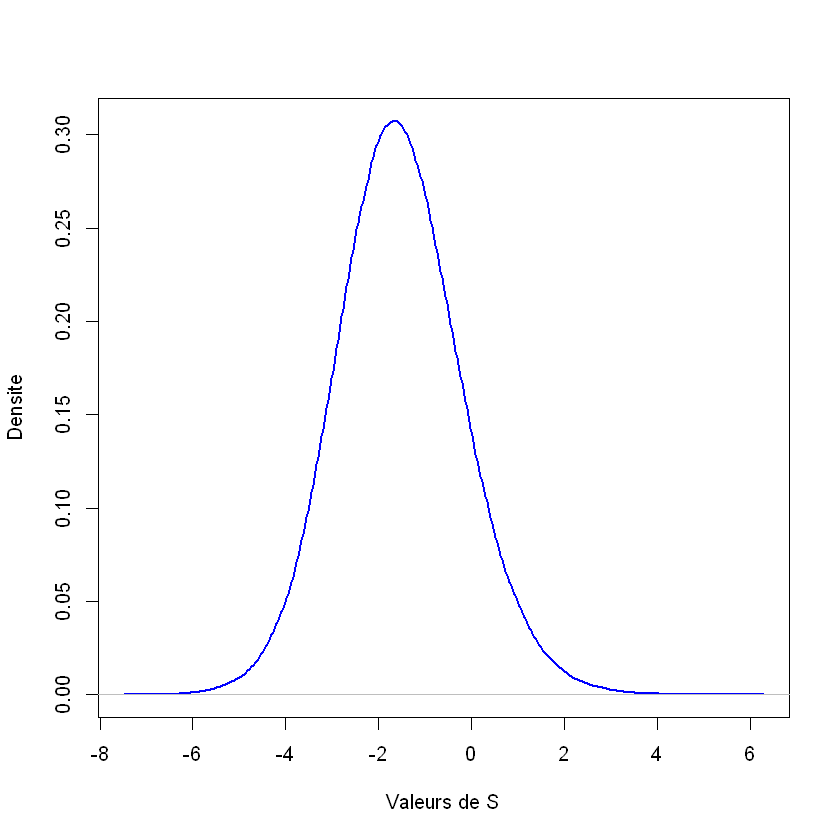

In [30]:
density_hd = density(h_d)
plot(density_hd, col = "blue", main="", lwd = 2, xlab = "Valeurs de S", ylab = "Densite")

#### Perspectives

On pourrait rajouter une marge de sécurité dans les modèles car il y a des causes comme le changement climatique par exemple qui peuvent influencer la hauteur de l'eau. En l'occurence, le changement climatique fait augmenter le niveau d'eau. Il faut prendre en compte les mesures de débit et du niveau d'eau qui sont bruités.